In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize, TweetTokenizer
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /Users/19598961/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/19598961/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/19598961/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [3]:
sentence_examples = {
    "high_readability": "The sun rises in the east every morning.",
    "low_readability": "The intricacies of quantum mechanics, as expounded upon by renowned physicists, continue to baffle even the most astute scholars.",
    "high_formality": "Esteemed Colleague, I extend cordial greetings. I wish to apprise you of the impending corporate meeting slated for the 15th of March. Your attendance would be highly appreciated.",
    "low_formality": "Hey! Quick heads up – we've got a meeting on March 15. It'd be awesome if you could make it. Can't wait to catch up!",
    "high_concreteness": "I can smell the flowers and feel the warmth of the sun as I walk through the colorful garden.",
    "low_concreteness": "The beauty and calmness of nature create a sense of harmony and connection.",
}

# Readability

In [4]:
def count_syllables(word: str) -> int:
    word = word if type(word) is str else str(word)
    word = word.lower()

    if len(word) <= 3:
        return 1

    word = re.sub('(?:[^laeiouy]es|[^laeiouy]e)$', '', word)
    word = re.sub('^y', '', word)
    matches = re.findall('[aeiouy]{1,2}', word)
    return len(matches)

def count_words(text: str):
    tokens = TweetTokenizer().tokenize(text)
    word_count = 0
    for t in tokens:
        if re.match('^[.,\/#!$%\'\^&\*;:{}=\-_`~()]$', t) is None:
            word_count += 1
    
    return word_count

def compute_readability(text: str) -> float:
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    syllable_count = 0
    word_count = 0
    for t in tokens:
        if re.match('^[.,\/#!$%\'\^&\*;:{}=\-_`~()]$', t) is None:
            word_count += 1
            word_syllable_count = count_syllables(t)
            syllable_count += word_syllable_count

    sentence_count = len(sent_tokenize(text))

    return 206.835 - 1.015 * word_count / sentence_count - 84.6 * syllable_count / word_count

In [5]:
print(sentence_examples["high_readability"])
compute_readability(sentence_examples["high_readability"])

The sun rises in the east every morning.


82.39000000000001

In [6]:
print(sentence_examples["low_readability"])
compute_readability(sentence_examples["low_readability"])

The intricacies of quantum mechanics, as expounded upon by renowned physicists, continue to baffle even the most astute scholars.


18.350000000000023

# Formality

In [7]:
# List of all POS-tags in NLTK
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [8]:
def compute_formality(text: str) -> float:
    positive_tags = ["NN", "NNP", "NNPS", "NNS",
                     "JJ", "JJR", "JJS",
                     "IN", "TO",
                     "DT", "PDT", "WDT"]
    negative_tags = ["PRP", "PRP$", "WP", "WP$",
                     "VB", "VBD", "VBG", "VBN", "VBP", "VBZ",
                     "RB", "RBR", "RBS", "WRB",
                     "UH"]
    p_count, n_count = 0, 0
    for word, pos in nltk.pos_tag(nltk.word_tokenize(text)):
        if pos in positive_tags:
            p_count += 1
        elif pos in negative_tags:
            n_count += 1

    word_count = count_words(text)
    return (p_count / word_count - n_count / word_count + 1) * 50


In [9]:
print(sentence_examples["high_formality"])
compute_formality(sentence_examples["high_formality"])

Esteemed Colleague, I extend cordial greetings. I wish to apprise you of the impending corporate meeting slated for the 15th of March. Your attendance would be highly appreciated.


57.14285714285714

In [10]:
print(sentence_examples["low_formality"])
compute_formality(sentence_examples["low_formality"])

Hey! Quick heads up – we've got a meeting on March 15. It'd be awesome if you could make it. Can't wait to catch up!


44.0

# Concreteness

In [11]:
word_concreteness_df = pd.read_excel("../data/concreteness_dataset.xlsx").set_index("Word")["Conc.M"].squeeze()
word_concreteness_df

Word
a                 1.46
aardvark          4.68
aback             1.65
abacus            4.52
abandon           2.54
                  ... 
zebra crossing    4.56
zero tolerance    2.21
ZIP code          3.77
zoom in           3.57
zoom lens         4.81
Name: Conc.M, Length: 39954, dtype: float64

In [12]:
def compute_concreteness(word_concreteness_df: pd.Series, text: str) -> float:
    tokens = TweetTokenizer().tokenize(text)

    concreteness, n_words = 0, 0
    for t in tokens:
        if re.match('^[.,\/#!$%\'\^&\*;:{}=\-_`~()]$', t) is None:
            word = t.lower()
            if word in word_concreteness_df:
                concreteness += word_concreteness_df[word]
                n_words += 1
    
    return concreteness / n_words

In [13]:
print(sentence_examples["high_concreteness"])
compute_concreteness(word_concreteness_df, sentence_examples["high_concreteness"])

I can smell the flowers and feel the warmth of the sun as I walk through the colorful garden.


2.779375

In [14]:
print(sentence_examples["low_concreteness"])
compute_concreteness(word_concreteness_df, sentence_examples["low_concreteness"])

The beauty and calmness of nature create a sense of harmony and connection.


2.1261538461538465

# Real Dataset

In [15]:
pd.read_excel("../data/dataset_tronindv.xlsx", 1).head(5)

,,Правильный ответ,GigaChat,GigaChat ответил верно,ChatGPT,ChatGPT ответил верно,Claude,Claude ответил верно
0,"Giver some premises, conduct reasoning to answ...",True,"Based on the given premises, we can conclude t...",Да,Let's analyze the premises to determine whethe...,Да,"Okay, let's analyze this step-by-step:\nPremis...",Да
1,"Giver some premises, conduct reasoning to answ...",False,"Based on the given premises, we can conclude t...",Нет,Let's break down the premises and use logical ...,Нет,"Okay, let's analyze this step-by-step:\n\nPrem...",Да
2,"Giver some premises, conduct reasoning to answ...",False,"Based on the given premises, we can conclude t...",Да,Let's break down the premises given:\n\n1. All...,Нет,"Okay, let's analyze this step-by-step:\n\nPrem...",Да
3,"Giver some premises, conduct reasoning to answ...",False,"Based on the given premises, we can conclude t...",Нет,Let's break down the premises and conduct reas...,Нет,"Okay, let's analyze this step-by-step:\n\nPrem...",Да
4,"Giver some premises, conduct reasoning to answ...",True,"Based on the given premises, we can conclude t...",Нет,Let's break down the premises and reason throu...,Да,"Okay, let's analyze this step-by-step:\n\nPrem...",Да


In [16]:
df_total = {}
df_total["prompt"] = []
df_total["hal_gigachat"] = []
df_total["hal_chatgpt"] = []
df_total["hal_claude"] = []

In [17]:
df_0 = pd.read_excel("../data/dataset_tronindv.xlsx", sheet_name=0, nrows=20)
print(df_0["Промпт"].head(5))
print(f'Sum: {((df_0["GigaChat ответил верно"] == "Да") | (df_0["GigaChat ответил верно"] == "Нет")).sum()}')
print(f'Sum: {((df_0["ChatGPT ответил верно"] == "Да") | (df_0["ChatGPT ответил верно"] == "Нет")).sum()}')
print(f'Sum: {((df_0["Claude ответил верно"] == "Да") | (df_0["Claude ответил верно"] == "Нет")).sum()}')

df_total["prompt"].extend(df_0["Промпт"].values)
df_total["hal_gigachat"].extend((df_0["GigaChat ответил верно"] == "Нет").values)
df_total["hal_chatgpt"].extend((df_0["ChatGPT ответил верно"] == "Нет").values)
df_total["hal_claude"].extend((df_0["Claude ответил верно"] == "Нет").values)

0          Can you explain what is ology?
1        Can you explain what is playset?
2       Can you explain what is footwell?
3      Can you explain what is fathering?
4    Can you explain what is conjunctiva?
Name: Промпт, dtype: object
Sum: 20
Sum: 20
Sum: 20


In [18]:
df_1 = pd.read_excel("../data/dataset_tronindv.xlsx", sheet_name=1, nrows=20)
print(df_1[" "].head(5))
print(f'Sum: {((df_1["GigaChat ответил верно"] == "Да") | (df_1["GigaChat ответил верно"] == "Нет")).sum()}')
print(f'Sum: {((df_1["ChatGPT ответил верно"] == "Да") | (df_1["ChatGPT ответил верно"] == "Нет")).sum()}')
print(f'Sum: {((df_1["Claude ответил верно"] == "Да") | (df_1["Claude ответил верно"] == "Нет")).sum()}')

df_total["prompt"].extend(df_1[" "].values)
df_total["hal_gigachat"].extend((df_1["GigaChat ответил верно"] == "Нет").values)
df_total["hal_chatgpt"].extend((df_1["ChatGPT ответил верно"] == "Нет").values)
df_total["hal_claude"].extend((df_1["Claude ответил верно"] == "Нет").values)

0    Giver some premises, conduct reasoning to answ...
1    Giver some premises, conduct reasoning to answ...
2    Giver some premises, conduct reasoning to answ...
3    Giver some premises, conduct reasoning to answ...
4    Giver some premises, conduct reasoning to answ...
Name:  , dtype: object
Sum: 20
Sum: 20
Sum: 20


In [19]:
df_2 = pd.read_excel("../data/dataset_tronindv.xlsx", sheet_name=2, nrows=19)
print(df_2["Промт"].head(5))
print(f'Sum: {((df_2["GigaChat ответил верно"] == "Да") | (df_2["GigaChat ответил верно"] == "Нет")).sum()}')
print(f'Sum: {((df_2["ChatGPT ответил верно"] == "Да") | (df_2["ChatGPT ответил верно"] == "Нет")).sum()}')
print(f'Sum: {((df_2["Claude ответил верно"] == "Да") | (df_2["Claude ответил верно"] == "Нет")).sum()}')

df_total["prompt"].extend(df_2["Промт"].values)
df_total["hal_gigachat"].extend((df_2["GigaChat ответил верно"] == "Нет").values)
df_total["hal_chatgpt"].extend((df_2["ChatGPT ответил верно"] == "Нет").values)
df_total["hal_claude"].extend((df_2["Claude ответил верно"] == "Нет").values)

0    Translate the next paragraphs into Russian. Be...
1    Translate the next paragraphs into Russian. Be...
2    Translate the next paragraphs into Russian. Be...
3    Translate the next paragraphs into Russian. Be...
4    Translate the next paragraphs into Russian. Be...
Name: Промт, dtype: object
Sum: 19
Sum: 19
Sum: 19


In [20]:
df_total["readability"] = [compute_readability(prompt) for prompt in df_total["prompt"]]
df_total["formality"] = [compute_formality(prompt) for prompt in df_total["prompt"]]
df_total["concreteness"] = [compute_concreteness(word_concreteness_df, prompt) for prompt in df_total["prompt"]]

In [21]:
for field in df_total:
    print(f"{field}: {len(df_total[field])}")

prompt: 59
hal_gigachat: 59
hal_chatgpt: 59
hal_claude: 59
readability: 59
formality: 59
concreteness: 59


In [25]:
pd_df_total = pd.DataFrame(df_total)
pd_df_total.head()

,prompt,hal_gigachat,hal_chatgpt,hal_claude,readability,formality,concreteness
0,Can you explain what is ology?,False,False,False,78.872857,28.571429,2.844000
1,Can you explain what is playset?,False,False,False,90.958571,14.285714,3.153333
2,Can you explain what is footwell?,True,False,False,90.958571,14.285714,2.844000
3,Can you explain what is fathering?,False,False,False,78.872857,14.285714,2.844000
4,Can you explain what is conjunctiva?,False,False,False,66.787143,14.285714,2.844000


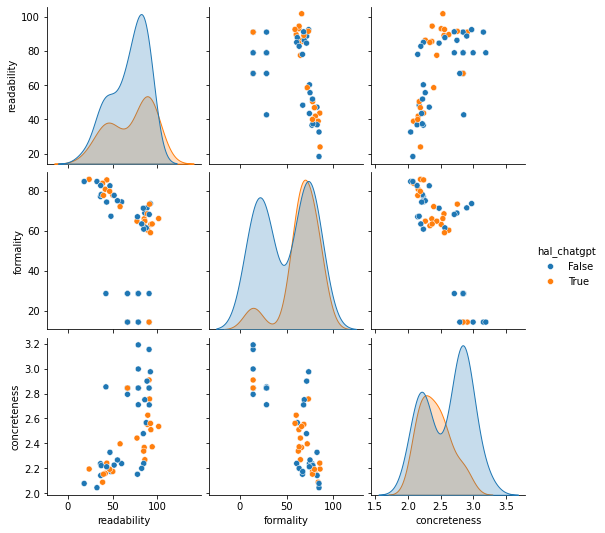

In [38]:
sns.pairplot(pd_df_total, vars=["readability", "formality", "concreteness"], hue="hal_chatgpt")

In [37]:
pd_df_total[pd_df_total.formality < 50]

,prompt,hal_gigachat,hal_chatgpt,hal_claude,readability,formality,concreteness
0,Can you explain what is ology?,False,False,False,78.872857,28.571429,2.844000
1,Can you explain what is playset?,False,False,False,90.958571,14.285714,3.153333
2,Can you explain what is footwell?,True,False,False,90.958571,14.285714,2.844000
3,Can you explain what is fathering?,False,False,False,78.872857,14.285714,2.844000
4,Can you explain what is conjunctiva?,False,False,False,66.787143,14.285714,2.844000
5,Can you explain what is seediness?,True,False,False,78.872857,28.571429,2.710000
6,Can you explain what is followership?,False,False,False,66.787143,14.285714,2.844000
7,Can you explain what is restenosis?,False,False,False,66.787143,28.571429,2.844000
8,Can you explain what is lectionary?,False,False,False,66.787143,28.571429,2.844000
9,Can you explain what is soundwave?,False,False,False,90.958571,14.285714,2.844000
